## Preparation

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import re

In [3]:
df = pd.read_csv("python-repo-10-combined.csv")

# remove less useful fields, serve as main record
df.to_csv(
    "main.csv",
    index=False,
    columns=[
        "id", "full_name", "topics", "default_branch",
        "homepage", "description", "fork", "language",
        "license", "pushed_at", "created_at",
        "updated_at", "size", "forks_count", "stargazers_count",
        "watchers_count", "open_issues_count", "has_discussions",
        "has_downloads", "has_issues", "has_pages", "has_projects",
        "has_wiki", "is_template", "web_commit_signoff_required",
    ]
)

/var/folders/xn/t_nj5y1n4lv75t_v154rv5_h0000gn/T/ipykernel_10942/1539085434.py:1: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("python-repo-10-combined.csv")


### Monthly New Repository Trends

In [4]:
df_main = pd.read_csv(
    "main.csv",
    parse_dates=[ "pushed_at", "created_at", "updated_at" ]
)
df_top = df_main[["full_name", "forks_count", "stargazers_count", "watchers_count", "open_issues_count", "created_at"]].sort_values("stargazers_count", ascending=False)
df_top.drop_dup
df_top['since'] = df_top['created_at'].dt.year
df_top['month'] = df_top['created_at'].dt.month
df_top = df_top.drop(columns=["created_at"])
df_monthly = df_top.groupby(["since", "month"]).agg(new_repos=pd.NamedAgg(column="full_name", aggfunc="count"))
df_monthly.reset_index(level=1, inplace=True)
df_monthly.reset_index(level=0, inplace=True)

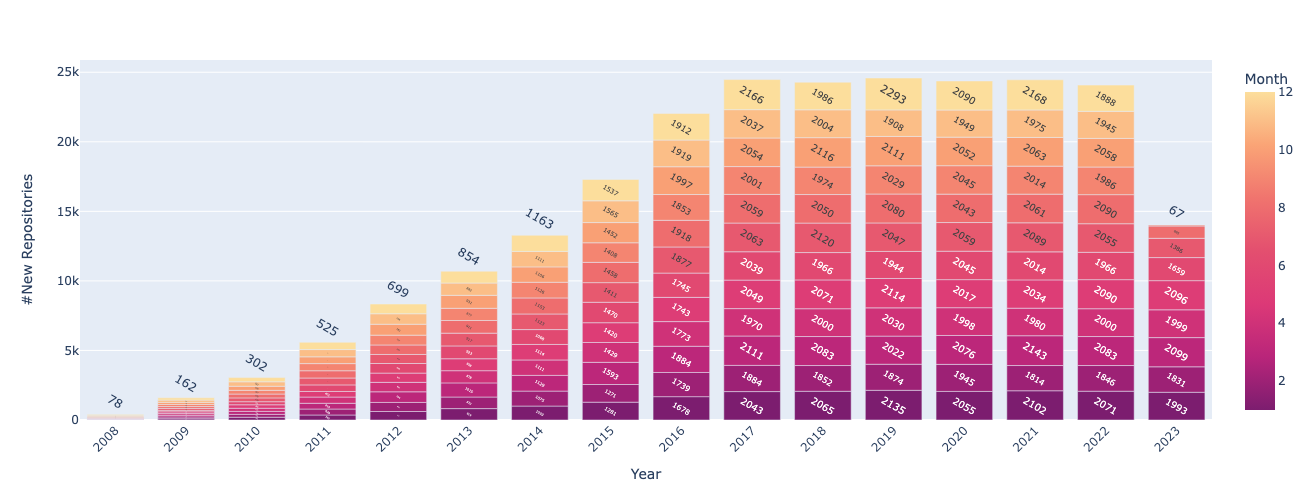

In [5]:
fig = px.bar(df_monthly, x="since", y="new_repos",
             color_continuous_scale=px.colors.sequential.Sunsetdark_r,
             color='month', barmode='stack', text="new_repos",
             labels={
                 "since": "Year",
                 "new_repos": "#New Repositories",
                 "month": "Month",
             },
             height=500)
fig.update_traces(textfont_size=12, textangle=30, cliponaxis=False)
fig.update_layout(xaxis={"dtick":1, "tickangle":-45})


fig.show()

## Topic analysis

In [6]:
def split_by_topics(row):
    topics = row['topics']
    row['topic'] = [m.group(1) for m in re.finditer(r"'([-\w]+)'", topics)]
    if len(row['topic']) == 0: row['topic'] = 'NOTOPIC'
    return row

def expand(file):
    df = pd.read_csv(file, parse_dates=['created_at', 'updated_at', 'pushed_at'])
    df = df.apply(lambda row: split_by_topics(row), axis=1)
    df = df.explode(['topic'])
    return df

df = expand("main.csv")
sum = df.groupby("topic").agg(
    repositories=pd.NamedAgg(column="id", aggfunc="count"),
    stars=pd.NamedAgg(column="stargazers_count", aggfunc="sum"),
    folks=pd.NamedAgg(column="forks_count", aggfunc="sum"),
    watchers=pd.NamedAgg(column="watchers_count", aggfunc="sum"),
).sort_values("repositories", ascending=False)

df['year'] = df['created_at'].dt.year
sum2 = df.groupby(["year", "topic"]).agg(
    topic_members=pd.NamedAgg(column="id", aggfunc="count"),
    topic_stars=pd.NamedAgg(column="stargazers_count", aggfunc="sum"),
    topic_forks=pd.NamedAgg(column="forks_count", aggfunc="sum"),
)


df_vis = sum2.query("topic_members > 15")
df_vis.reset_index(level=1, inplace=True)
df_vis.reset_index(level=0, inplace=True)


### Prepare dataframe for treemap and sunburst

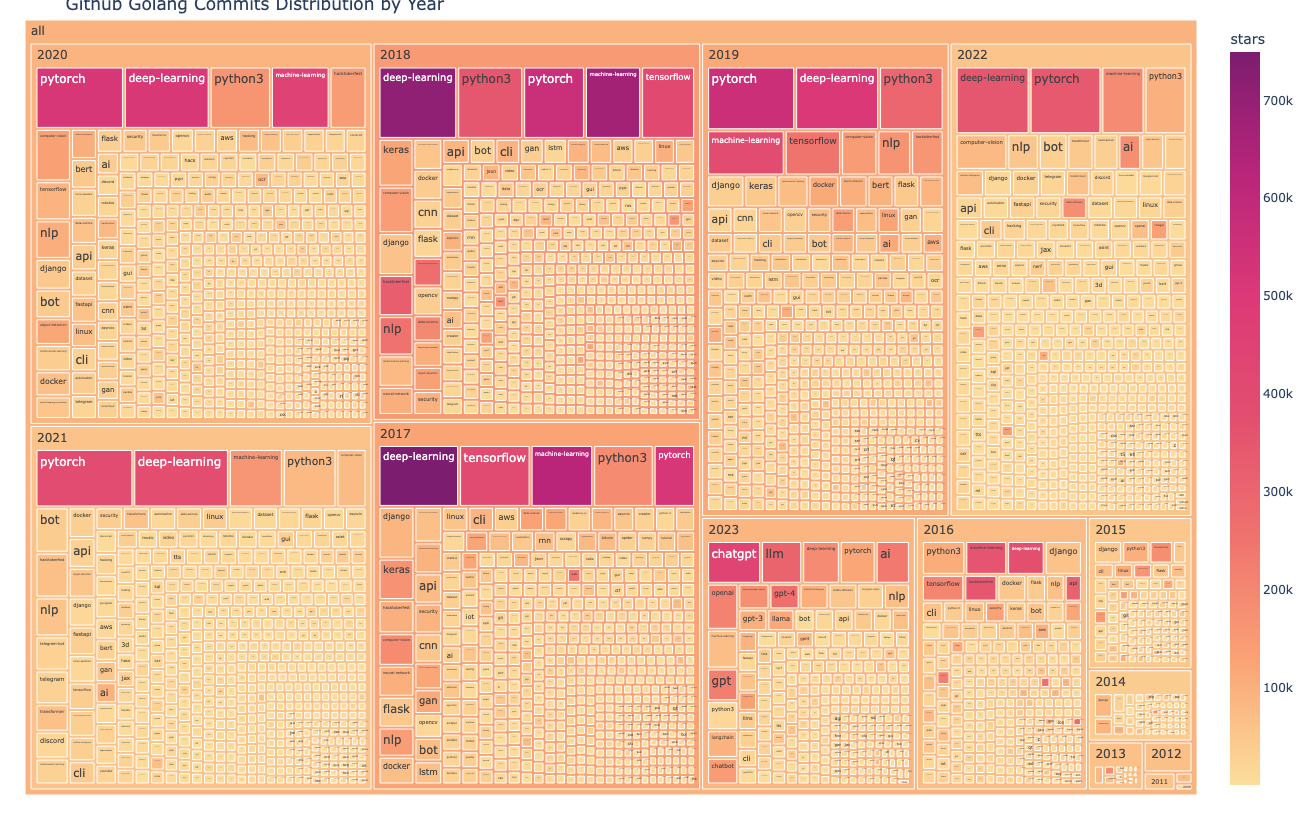

In [11]:
df_vis = df_vis.query("topic != 'NOTOPIC' and topic != 'python'")
fig = px.treemap(
    df_vis, path=[px.Constant("all"), 'year', 'topic'],
    values='topic_members',
    #color_continuous_scale=px.colors.sequential.Sunset,
    color_continuous_scale=px.colors.sequential.Sunsetdark,
    color='topic_stars',
    width=1200, height=820,
    labels={
        "topic_stars": "stars",
        "topic_forks": "forks",
    },
    title="Github Golang Commits Distribution by Year")
fig.update_layout(margin = dict(t=20, l=25, r=25, b=25))
fig.show()